In [90]:
import argparse
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt


def question_bank(question):
    if question[:3] == 'sim':
        return '-'
    elif question[:3] == 'nat':
        return question[4]
    return 'Error'


def load_results_df(path_saves, path_listener_info, hidden_ref_min):
    df_results = pd.DataFrame()
    df_info = load_listener_info(path_listener_info)
    

    # read all csv results files and create dataframe
    for filename in os.listdir(path_saves):
        if filename.endswith(".csv") and filename[3] == '-':
            path_file = path_saves / filename
            
            df_file = pd.read_csv(path_file)
            df_file = df_file.melt(id_vars=['file_keys'])
            
            df_results = pd.concat([df_results, df_file], ignore_index=True)
            

    # rename columns and unpivot to have each row with a single question answer
    df_results.rename(columns={'variable':'question'}, inplace=True)

    # add info about question. Model, and what question bank it came from, eg. t=tricky, a=alexia (only for nat)
    df_results['question_type'] = df_results['question'].str[:3]
    df_results['model'] = df_results.question.str[-3:]
    df_results['question_meta'] = df_results.question.str[:-4]
    df_results['question_bank'] = df_results.question.apply(question_bank)
    df_results['ref_above_min'] = df_results['value'].apply(lambda x: True if x > hidden_ref_min else False)
    df_results = df_results.merge(df_info, on='file_keys', how='left')
    return df_results


def load_listener_info(path_info):
    df_info = pd.read_csv(path_info)
    return df_info
    


def get_passed(df_results, question_type, avg_ref_min, is_headphones=False,
                       is_quiet_or_headphones=False, english_min=0.25, is_quiet=False):
    # Return a list of unique ids (file_keys) that scored the natural reference high enough consistently
    
    df_results_nat_ref = df_results[(df_results['question_type'] == question_type) * (df_results['model']=='ref')]
    avg_ref = df_results_nat_ref.groupby('file_keys')['ref_above_min'].mean()  # ref_above_min is 1 or 0, so mean is pct above min

    nat_passed = avg_ref[avg_ref > avg_ref_min].index
    print(f'{question_type} ref_min: {len(nat_passed)}')
    
    if is_headphones:
        nat_headphones = df_results[(df_results.headphones == 1) * (df_results['question_type'] == question_type)].file_keys
        nat_passed = nat_passed[nat_passed.isin(nat_headphones)]
        print(f'headphones: {len(nat_headphones.unique())}')
    if is_quiet:
        nat_quiet = df_results[(df_results.quiet == 1) * (df_results['question_type'] == question_type)].file_keys
        nat_passed = nat_passed[nat_passed.isin(nat_quiet)]
        print(f'quiet: {len(nat_quiet.unique())}')
    if is_quiet_or_headphones:
        nat_quiet_filter = (df_results.quiet == 1) * (df_results['question_type'] == question_type)
        nat_headphones_filter = (df_results.headphones == 1) * (df_results['question_type'] == question_type)
        nat_quiet_or_headphones_filter = (nat_quiet_filter + nat_headphones_filter) > 0
        nat_quiet_or_headphones = df_results[nat_quiet_or_headphones_filter].file_keys
        # nat_quiet_or_headphones = df_results[(df_results.quiet == 1 | df_results.headphones == 1) * (df_results['question_type'] == question_type)].file_keys
        nat_passed = nat_passed[nat_passed.isin(nat_quiet_or_headphones)]
        print(f'quiet or headphones: {len(nat_quiet_or_headphones.unique())}')
    
    nat_english_min = df_results[(df_results['question_type']==question_type) * (df_results['english']>english_min)].file_keys
    nat_english_min = nat_english_min.unique()
    print(f'english_min: {len(nat_english_min)}')
    nat_passed = nat_passed[nat_passed.isin(nat_english_min)]
    
    nat_failed = df_results[(~df_results['file_keys'].isin(nat_passed)) * (df_results['question_type']==question_type)].name
    print(f'{question_type} failed:\n{nat_failed.unique()}')
    
    return nat_passed


def get_nat_processed_results(df_results, avg_nat_ref_min, is_headphones=False,
                              is_quiet=False, is_quiet_or_headphones=False,
                              english_min=0.25, question_bank_select=None):
    # get list of ids that passed
    nat_passed = get_passed(df_results, 'nat', avg_nat_ref_min, is_headphones=is_headphones,
                                    is_quiet=is_quiet, is_quiet_or_headphones=is_quiet_or_headphones, english_min=english_min)
    print(f'{len(nat_passed)} participants passed naturalness')
    # given results and ids of who passed, return a dictionary of scores for each model
    results_nat = {'ref': None, 'mel': None, 'v08': None, 'v09': None, 'v10': None}
    nat_models = ['ref', 'mel', 'v08', 'v09', 'v10']

    if question_bank_select == None:
        for model in nat_models:
            results_nat[model] = np.array(df_results[(df_results['question_type'] == 'nat') *
                                                 (df_results['model'] == model) *
                                                 (df_results['file_keys'].isin(nat_passed))
                                                 ].value.tolist())
    else:
        for model in nat_models:
            results_nat[model] = np.array(df_results[(df_results['question_type'] == 'nat') *
                                                    (df_results['model'] == model) *
                                                    (df_results['file_keys'].isin(nat_passed)) *
                                                    (df_results['question_bank']==question_bank_select)
                                                    ].value.tolist())
    
    return results_nat  # dictionary of results


def get_sim_processed_results(df_results, avg_sim_ref_min, is_headphones=False,
                              is_quiet=False, is_quiet_or_headphones=False,
                              english_min=0.25):
    # get list of ids that passed
    sim_passed = get_passed(df_results, 'sim', avg_sim_ref_min, is_headphones=is_headphones,
                                    is_quiet=is_quiet, is_quiet_or_headphones=is_quiet_or_headphones, english_min=english_min)
    print(f'{len(sim_passed)} participants passed similarity')
    results_sim = {'ref': None, 'mel': None, 'v09': None}
    sim_models = ['ref', 'mel', 'v09']

    for model in sim_models:
        results_sim[model] = np.array(df_results[(df_results['question_type'] == 'sim') *
                                                 (df_results['model'] == model) *
                                                 (df_results['file_keys'].isin(sim_passed))
                                                ].value.tolist())
    return results_sim  #dictionary of results


def bootstrap_results(results_type, nb_bootstrap=5000):
    # given a dictionary of results and the number of times to iterate bootstrap, calculate the mean and confidence intervals
    results_mean = {}

    # get the list of results for a specific model, eg. mel
    for model in results_type:
        results = results_type[model]
        N = len(results)
        results_mean[model] = {}
        # calculate the given mean from the original sample
        results_mean[model]['mean'] = results.mean()    
        
        # now repeat bootstrap and calculate distribution of means
        mean_list = []
        for n in range(int(nb_bootstrap)):
            random_sample = np.random.choice(results, size=N, replace=True)
            mean_list.append(random_sample.mean())
        mean_list.sort()
        
        # get the 95% confidence intervals
        lower_index = int(0.025 * nb_bootstrap)
        upper_index = int(0.975 * nb_bootstrap)
        results_mean[model]['lower'] = mean_list[lower_index]
        results_mean[model]['upper'] = mean_list[upper_index]
        
    return results_mean  # dictionary of mean, and CI for each model


def print_results_mean(results_mean, question_type):
    print(f'*****************')
    print(f'{question_type:17}')
    print(f'*****************')
    for model in results_mean:
        mean = results_mean[model]['mean']
        lower = results_mean[model]['lower']
        upper = results_mean[model]['upper']
        print(f'{model}:\n    mean: {mean:0.3f}\n    CI: [{lower:0.3f}, {upper:0.3f}]\n')


def hist_with_CI(ax, results_mean, label_dict, title):
    # Sample data
    means = []
    lower_bounds = []
    upper_bounds = []
    labels=[]
    for model in results_mean:
        means.append(results_mean[model]['mean'])
        lower_bounds.append(results_mean[model]['lower'])
        upper_bounds.append(results_mean[model]['upper'])
        labels.append(label_dict[model])

    # Create a figure and axis

    bar_width = 0.35

    # Plot means with error bars (confidence intervals)
    ax.bar(labels, means, bar_width, label='Mean')
    ax.errorbar(labels, means, yerr=[means[i] - lower_bounds[i] for i in range(len(means))], fmt='.', label='95% confidence', color='black')


    # Add a legend
    ax.legend()

    # Add labels and title
    # ax.set_xlabel('Groups')
    ax.set_ylabel('Values')
    ax.set_title(title)


def boxplot_with_CI(ax, results, nb_bootstrap, title, label_dict):
    data = []
    labels = []
    for key in results:
        data.append(results[key])
        labels.append(label_dict[key])

    ax.boxplot(data, labels=labels, notch=True, bootstrap=nb_bootstrap)
    ax.set_ylabel('Values')
    ax.set_title(title)

In [91]:
hidden_ref_min=0.5
pct_natural_ref_passed=0.6
pct_sim_ref_passed=0.6
ratings_path='./../saves/ratings'
listener_info_path='./../saves/ratings/listener_info.csv'
is_headphones=False
is_quiet=False
is_quiet_or_headphones=True
english_min=0.5
question_bank_select = None    # either: 'a' 't' None

label_dict = {'ref':'Reference', 'mel':'mel', 'v08':'w2v_pt_L12', 'v09':'w2v_ft_L09', 'v10':'w2v_pt_L09'}

In [92]:
nb_bootstrap=5000
path_saves = Path(ratings_path)
path_listener_info = Path(listener_info_path)
hidden_ref_min = hidden_ref_min  # minimum score for ref for it to be classed as success
avg_nat_ref_min = pct_natural_ref_passed  # average success score for person's results to be used
avg_sim_ref_min = pct_sim_ref_passed  # average success score for person's results to be used

df_results = load_results_df(path_saves, path_listener_info, hidden_ref_min)
results_nat = get_nat_processed_results(df_results, avg_nat_ref_min, is_headphones=is_headphones,
                                        is_quiet=is_quiet, is_quiet_or_headphones=is_quiet_or_headphones,
                                        english_min=english_min, question_bank_select=question_bank_select)
results_nat_alexia = get_nat_processed_results(df_results, avg_nat_ref_min, is_headphones=is_headphones,
                                        is_quiet=is_quiet, is_quiet_or_headphones=is_quiet_or_headphones,
                                        english_min=english_min, question_bank_select='a')
results_nat_test = get_nat_processed_results(df_results, avg_nat_ref_min, is_headphones=is_headphones,
                                        is_quiet=is_quiet, is_quiet_or_headphones=is_quiet_or_headphones,
                                        english_min=english_min, question_bank_select='t')
results_sim = get_sim_processed_results(df_results, avg_sim_ref_min, is_headphones=is_headphones,
                                        is_quiet=is_quiet, is_quiet_or_headphones=is_quiet_or_headphones, english_min=english_min)
nat_results_mean = bootstrap_results(results_nat, nb_bootstrap=nb_bootstrap)
nat_results_mean_alexia = bootstrap_results(results_nat_alexia, nb_bootstrap=nb_bootstrap)
# nat_results_mean_test = bootstrap_results(results_nat_test, nb_bootstrap=nb_bootstrap)
sim_results_mean = bootstrap_results(results_sim, nb_bootstrap=nb_bootstrap)

print_results_mean(nat_results_mean, 'Naturalness')
print_results_mean(sim_results_mean, 'Similarity')

nat ref_min: 41
quiet or headphones: 50
english_min: 48
nat failed:
['Jake Egbers' 'Franck Barga' 'Hanson ' 'Emily Delve' 'David Dunkley'
 'George' 'Mike Jones' 'Stephen Lay' 'Tom Emberson' 'Philipp' 'Ross']
39 participants passed naturalness
nat ref_min: 41
quiet or headphones: 50
english_min: 48
nat failed:
['Jake Egbers' 'Franck Barga' 'Hanson ' 'Emily Delve' 'David Dunkley'
 'George' 'Mike Jones' 'Stephen Lay' 'Tom Emberson' 'Philipp' 'Ross']
39 participants passed naturalness
nat ref_min: 41
quiet or headphones: 50
english_min: 48
nat failed:
['Jake Egbers' 'Franck Barga' 'Hanson ' 'Emily Delve' 'David Dunkley'
 'George' 'Mike Jones' 'Stephen Lay' 'Tom Emberson' 'Philipp' 'Ross']
39 participants passed naturalness
sim ref_min: 26
quiet or headphones: 47
english_min: 45
sim failed:
['Franck Barga' 'Hanson ' 'James grant ' 'Monica Davidson' 'Alex'
 'Chloé Francois' 'Jacob Pope' 'David Dunkley' 'Steve Nash' 'Emily Delve'
 'Tony Clarke' 'Tertia Nash' 'John Keast' 'Jake Egbers' 'Peter 

/home/fred/miniconda3/envs/deepzen-v1/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_699/123508472.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


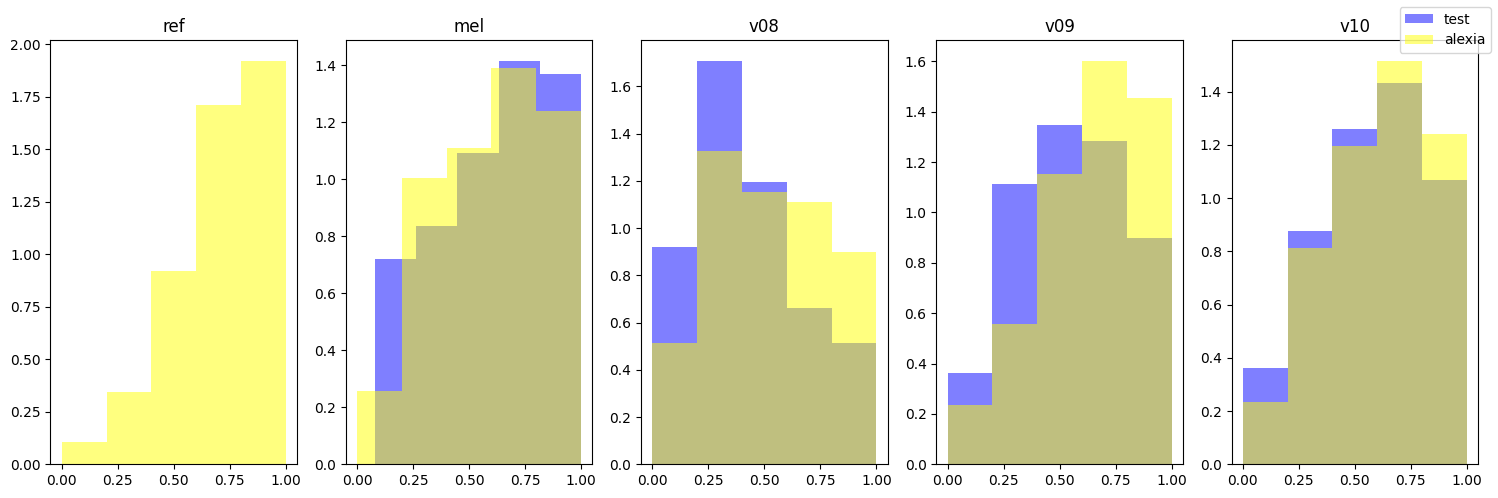

In [93]:
alpha = 0.5
colours = ['red', 'blue', 'yellow']

fig, axs = plt.subplots(1, 5, figsize=(15,5))
axs_flatten = axs.flatten()

for i, model in enumerate(results_nat):
    ax = axs_flatten[i]
    
    #ax.hist(results_nat[model], bins=5, alpha=alpha, color=colours[0], label='all', density=True)
    ax.hist(results_nat_test[model], bins=5, alpha=alpha, color=colours[1], label='test', density=True)
    ax.hist(results_nat_alexia[model], bins=5, alpha=alpha, color=colours[2], label='alexia', density=True)
    ax.set_title(model)
    if i==0:
        fig.legend()
fig.tight_layout()
fig.show()

/tmp/ipykernel_699/508313180.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


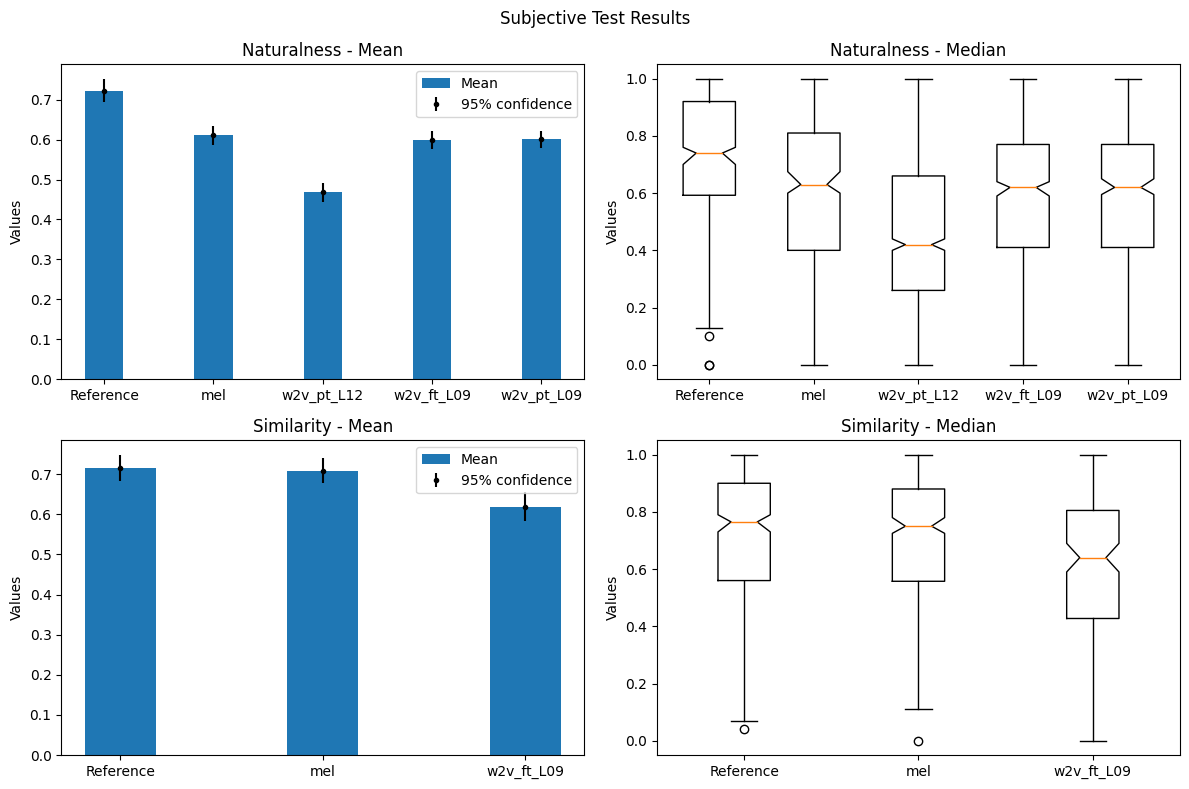

In [94]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
axs_flatten = axs.flatten()

hist_with_CI(axs_flatten[0], nat_results_mean, label_dict, 'Naturalness - Mean')
boxplot_with_CI(axs_flatten[1], results_nat, nb_bootstrap, 'Naturalness - Median', label_dict)
hist_with_CI(axs_flatten[2], sim_results_mean, label_dict, 'Similarity - Mean')
boxplot_with_CI(axs_flatten[3], results_sim, nb_bootstrap, 'Similarity - Median', label_dict)

fig.suptitle('Subjective Test Results')
fig.tight_layout()
fig.show()

In [95]:
df_results

,file_keys,question,value,question_type,model,question_meta,question_bank,ref_above_min,type,name,headphones,quiet,english
0,ET9F5TIG9oSdD9ZTkyGSE4xBecY7UiYh,sim-08-mel,0.76,sim,mel,sim-08,-,True,sim,Franck Barga,1,1,1.0
1,77NNzH0kH24g89ya9mPmPs2YUlEg2pOG,sim-08-mel,0.73,sim,mel,sim-08,-,True,sim,Jenn,1,1,1.0
2,bWzu4H4ypRIrzQj62GWMlPsvZd6OzxlK,sim-08-mel,0.92,sim,mel,sim-08,-,True,sim,Nicola,1,1,1.0
3,GDTqeEBE4I8X2VCCpj7yJXoKwMGn8f6s,sim-08-mel,0.57,sim,mel,sim-08,-,True,sim,Hanson,0,1,1.0
4,aupZvNqSd9b68Z6aNFPOgWzqPop8efx1,sim-08-mel,0.71,sim,mel,sim-08,-,True,sim,James grant,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823,sXMD1G6rwEPgYFFX8a1RYqUAxrgg6ANc,nat-t-13-v10,0.92,nat,v10,nat-t-13,t,True,nat,Cass Murray,1,1,1.0
3824,TOi1LVyXLXAq5QSEwx12MMH8bh4RJbsK,nat-t-13-v10,0.48,nat,v10,nat-t-13,t,False,nat,Ross,1,1,1.0
3825,Mj2WOQ4jfRzMsWtJBU54SiiC70zeJ1Pv,nat-t-13-v10,0.93,nat,v10,nat-t-13,t,True,nat,Gary Adamson,1,1,1.0
3826,EgDliNfgbohD8Ovvs6yTiDA6npFyyS7g,nat-t-13-v10,0.69,nat,v10,nat-t-13,t,True,nat,Patrick,1,1,1.0


In [105]:
len(results_nat['mel'])

468

Check that paired data is in the right order, ie. index i for v08 is paired with index i for mel (in nat results, and sim_results)

In [117]:
# Select question type: [nat, sim]
question_type = 'nat'


if question_type == 'sim':
    results_to_check = results_sim
    models = {'mel':0, 'v09':0}
if question_type == 'nat':
    results_to_check = results_nat
    models = {'mel':0, 'v08':0, 'v09':0, 'v10':0}

for i in range(len(results_to_check['mel'])):
    for model in models:
        models[model] = results_to_check[model][i]

    df_file_keys = df_results.file_keys.drop_duplicates()
    df_questions_meta = df_results.question_meta.drop_duplicates()

    for model in models:
        results_filter = ((df_results['question_type']==question_type) *
                        (df_results['model']==model) *
                        (df_results['value']==models[model])
        )
        df_file_keys = df_file_keys[df_file_keys.isin(df_results[results_filter].file_keys)]
        df_questions_meta = df_questions_meta[df_questions_meta.isin(df_results[results_filter].question_meta)]
    file_key = list(df_file_keys)
    question_meta = list(df_questions_meta)
    result = df_results[(df_results['file_keys'].isin(file_key)) * (df_results['question_meta'].isin(question_meta))]
    
    if len(result) > 0 and len(question_meta) > 0:
        pass
    else:
        print(f'FAIL: row {i}')

Wilcoxen signed rank test to check the null hypothesis if the means are different from the MUSHRA test
 - not assuming normality
 - Assuming independence between the pairs of results
 - Assuming dependence between the pairs of results
 - using bonferroni adjustment of alpha due to applying multiple paird p-value tests

In [122]:
from scipy.stats import wilcoxon

alpha = 0.05 / 4

print('Naturalness Test')
models = ['v08', 'v09', 'v10']
results_base = results_nat['mel']
for model in models:
    results_model = results_nat[model]
    res = wilcoxon(results_base, results_model)
    print(f'mel vs {model}\n - w: {res.statistic:0.0f}\n - p-val: {res.pvalue:0.3f}\n')


print('Similarity Test')
results_base = results_sim['mel']
models = ['v09']
for model in models:
    results_model = results_sim[model]
    res = wilcoxon(results_base, results_model)
    print(f'mel vs {model}\n - w: {res.statistic:0.0f}\n - p-val: {res.pvalue:0.3f}\n')

Naturalness Test
mel vs v08
 - w: 23351
 - p-val: 0.000

mel vs v09
 - w: 45234
 - p-val: 0.220

mel vs v10
 - w: 46324
 - p-val: 0.460

Similarity Test
mel vs v09
 - w: 4987
 - p-val: 0.000

